<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/ensemble-methods-for-machine-learning/01-ensemble-methods/model_averaging_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##A Simple Model Averaging Ensemble

We will build our first ensemble with model averaging for a regression task on the classic benchmark **Boston Housing** data set. 

First, we load the data set and then standardize the data to be zero-mean, unit standard deviation, and the labels to be in the range [-1, 1]. 

After standardization, split into training and test sets (67%-33%).

##Setup

In [2]:
#from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score

from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor

from itertools import combinations
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
%matplotlib inline

##Dataset

In [8]:
# X, y = load_boston(return_X_y=True)
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [9]:
X = StandardScaler().fit_transform(data)
y = StandardScaler().fit_transform(target.reshape(-1, 1)).ravel()

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

##Diverse base estimators

Now, we learn several different different regressors (mostly using default settings).

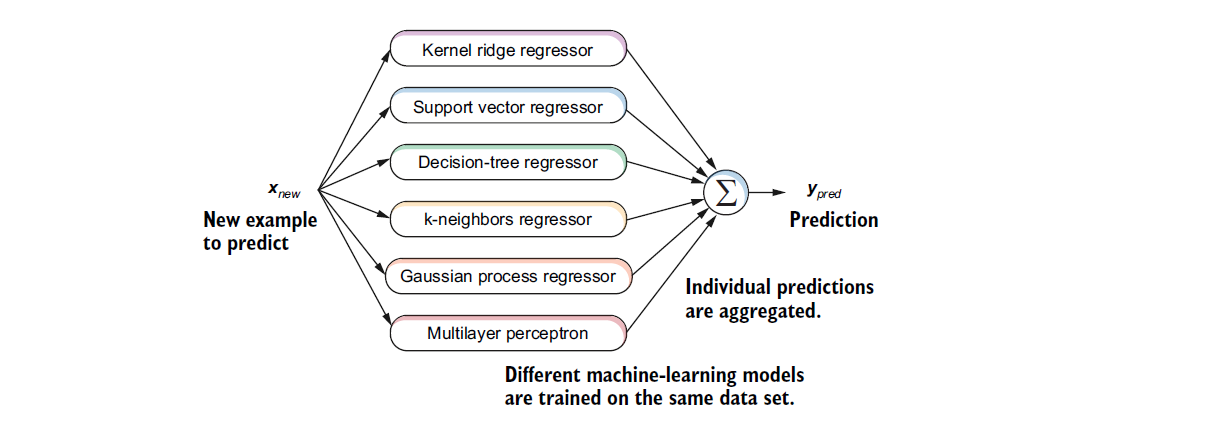

In [10]:
estimators = {
  "krr": KernelRidge(kernel="rbf", gamma=0.25),
  "svr": SVR(gamma=0.5),
  "dtr": DecisionTreeRegressor(max_depth=8),
  "knn": KNeighborsRegressor(n_neighbors=3),
  "gpr": GaussianProcessRegressor(alpha=1e-1),
  "mlp": MLPRegressor(alpha=25, max_iter=1000)
}

for name, estimator in estimators.items():
  estimator = estimator.fit(x_train, y_train)

##Aggregating predictions 

Once we have trained the individual base estimators, we can make individual predictions and then aggregate them into a final **ensemble prediction**. 

As this is a regression problem, the aggregator is the average, and thus, this approach is known as model averaging.

In [11]:
n_estimators, n_samples = len(estimators), x_test.shape[0]

y_individual = np.zeros((n_samples, n_estimators))
for i, (model, estimator) in enumerate(estimators.items()):
  y_individual[:, i] = estimator.predict(x_test)
y_final = np.mean(y_individual, axis=1)

##Plot test performances

One way to understand the benefits of ensembling is if we look at all possible combinations of models for predictions. That is, we look at the performance of one model at a time, then all possible ensembles of two models (there are 15 such combinations), then all possible ensembles of three models (there are 20 such combinations) and so on. 

For ensemble size 1 to 6, we plot the test set performances of all these ensemble combinations.

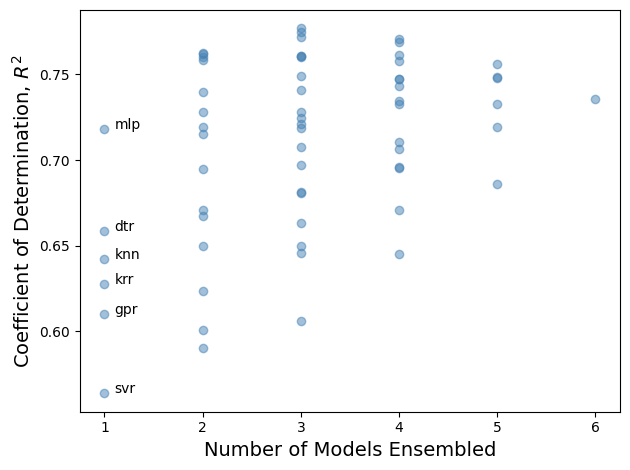

In [14]:
models = list(estimators.keys())
combo_mean = np.zeros((len(estimators), ))
combo_std = np.zeros((len(estimators), ))

fig = plt.figure();

for n_ensemble in range(len(estimators)):
    # Get all possible combinations of models of length n_ensemble
    combos = combinations(estimators, n_ensemble + 1)
        
    # Get the average of individual predictions for each combination
    averaged_predictions = [np.mean(np.array([y_individual[:, models.index(e)] for e in list(c)]), axis=0) for c in combos]
    averaged_r2 = [r2_score(y_test, ypred) for ypred in averaged_predictions]
    
    n_combos = len(averaged_r2)
    
    plt.scatter(np.full((n_combos, ), n_ensemble + 1), averaged_r2, color='steelblue', alpha=0.5)
    combo_mean[n_ensemble] = np.mean(averaged_r2)
    combo_std[n_ensemble] = np.std(averaged_r2)
    
    if n_ensemble == 0:
        for r, name in zip(averaged_r2, estimators):
            plt.text(1.1, r, name)
            
plt.xlabel('Number of Models Ensembled', fontsize=14);
plt.ylabel('Coefficient of Determination, $R^2$', fontsize=14);
fig.tight_layout()
plt.show()

As we aggregate more and more models, we see that the ensembles generalize increasingly better. The most striking result of our experiment, though, is that the performance of the ensemble of all 6 estimators is often (across several runs) better than the performances of each individual estimator.

##Fit vs Complexity

Finally, what of fit vs. complexity? 

It is difficult to characterize the complexity of the ensemble, as different types of estimators in our ensemble have different complexities. 

However, we can characterize the variance of the ensemble.

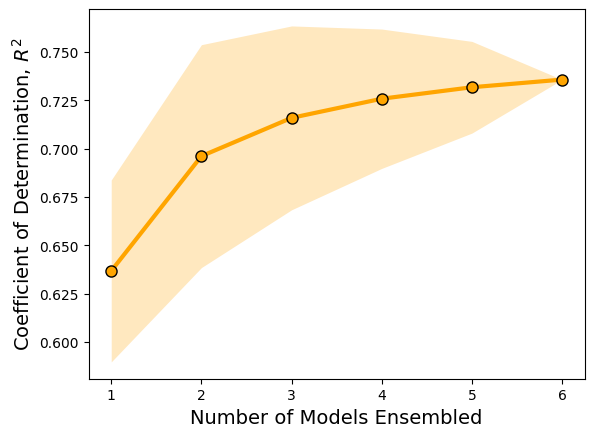

In [15]:
%matplotlib inline

fig = plt.figure()
plt.fill_between(np.arange(1, len(estimators) + 1), combo_mean - combo_std, combo_mean + combo_std, color='orange', alpha=0.25, linewidth=0);
plt.plot(np.arange(1, len(estimators) + 1), combo_mean, marker='o', color='orange', markersize=8, markeredgecolor='k', linewidth=3);
plt.xlabel('Number of Models Ensembled', fontsize=14);
plt.ylabel('Coefficient of Determination, $R^2$', fontsize=14);
plt.show()

As ensemble size increases, the variance of the ensemble decreases! This is a consequence of model aggregation or averaging. We know that averaging “smooths out the rough edges”. 

The overall ensemble is more robust to mistakes, and unsurprisingly, generalizes better than any single base estimator.